<a href="https://colab.research.google.com/github/voquangtuong/AAA_drought_prediction/blob/main/multiple_output_steps_parallel12months_optimalscaled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive')

In [ ]:
output_directories=['out_fig_MO','out_tab_MO']
for output_directory in output_directories:
  if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [ ]:
!pip install livelossplot --quiet

In [ ]:
# multivariate multi-step encoder-decoder lstm example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as KK
from keras import optimizers
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# Customize functions

In [ ]:
# =============================================================================
# Customize activate functions
# huber loss
def huber(true, pred, delta):
    loss = np.where(np.abs(true-pred) < delta , 0.5*((true-pred)**2), delta*np.abs(true - pred) - 0.5*(delta**2))
    return np.sum(loss)
# Custom activation function
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


def custom_activation2(x):
    return (K.tanh(x) * 100) 

get_custom_objects().update({'custom_activation2': Activation(custom_activation2)})

# Huber losss
def custom_activation1(x):
    
    return (K.tanh(x) * 1.5) 

get_custom_objects().update({'custom_activation1': Activation(custom_activation1)})

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 

In [ ]:

# # define input sequence
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# reading cluster results
cluster_df=pd.read_csv('/content/drive/MyDrive/output_tab_cluster/cluster_df.csv')
cluster_df.head()


,Unnamed: 0,clusters,zones
0,0,Cluster 1,Cheongju14
1,1,Cluster 1,Cheorwon54
2,2,Cluster 1,Chuncheon55
3,3,Cluster 1,Daedeok49
4,4,Cluster 1,Dangjin30


In [ ]:
# query Cluster1
i=0
list_cluster_name=cluster_df.clusters.unique().tolist()
df=cluster_df
listi=df.loc[df['clusters'] == list_cluster_name[i]]['zones'].values.tolist()
listi

['Cheongju14',
 'Cheorwon54',
 'Chuncheon55',
 'Daedeok49',
 'Dangjin30',
 'Nowon255',
 'Okcheon23',
 'Ongjin166',
 'Osan92',
 'Pocheon94',
 'Pyeongtaek95',
 'Sacheon145',
 'Saha9',
 'Samcheok65',
 'Sancheong146',
 'Seo167']

In [ ]:
dataset1000=pd.read_csv("input_data/percentile_season_adj.csv")
dataset1000.head()

,Date,Andong106,Ansan75,Ansoeng76,Anyang77,Asan25,Boeun13,Bonghwa107,Boryeong26,Boseong186,Buan170,Buan171,Bucheon78,Buk0,Buk264,Buk41,Buk72,Bupyeong154,Busanjin1,Buyeo27,Changnyeong128,Changwon129,Changwon130,Cheonan28,Cheongdo108,Cheongju14,Cheongsong109,Cheongyang29,Cheorwon54,Chilgok110,Chuncheon55,Chungju15,Daedeok49,Dalseo42,Dalseong43,Damyang187,Dangjin30,Danyang16,Dobong240,Dong-daemun241,...,Wando224,Wando225,Wando226,Wando227,Wando228,Wando229,Wando230,Wando231,Wando232,Wanju185,Wonju68,Yangcheon261,Yanggu69,Yangju101,Yangpyeong102,Yangsan153,Yangyang70,Yecheon123,Yeoju103,Yeoncheon104,Yeongam233,Yeongcheon124,Yeongdeok125,Yeongdeungpo262,Yeongdo11,Yeongdong24,Yeonggwang234,Yeongi239,Yeongju126,Yeongwol71,Yeongyang127,Yeonje12,Yeosu235,Yeosu236,Yeosu237,Yeosu238,Yesan40,Yongin105,Yongsan263,Yuseong53
0,1/1/1981,-0.068793,0.007370,-0.043025,0.027512,-0.016300,-0.135790,-0.280612,-0.085975,0.000382,0.010484,0.006280,0.018972,-0.013240,0.180639,0.058954,0.111425,-0.348126,0.074321,0.030633,-0.136730,-0.106414,0.115682,0.074885,0.043213,-0.017936,-0.147586,-0.349976,-0.373941,0.027995,-0.300738,-0.288500,-0.020772,-0.163009,-0.087655,-0.246005,-0.101062,-0.279076,-0.350928,-0.245401,...,-0.013955,0.164799,0.067646,0.127357,-0.196007,-0.064919,0.124725,0.110258,0.109936,0.114082,-0.105871,-0.245509,-0.255475,-0.288880,-0.264224,-0.198930,-0.262297,-0.303282,-0.146950,-0.214944,-0.338890,-0.241755,-0.278760,-0.276730,-0.230615,-0.254436,-0.226088,-0.360223,-0.268837,-0.262598,-0.267553,-0.254590,-0.192182,-0.253589,-0.282550,-0.340427,-0.311349,-0.341370,-0.337228,-0.397738
1,2/1/1981,-0.191194,-0.237572,-0.179815,-0.001349,-0.172738,-0.127369,-0.152398,-0.155773,-0.229314,-0.231227,-0.231224,-0.244268,-0.213504,-0.594912,0.036537,-0.184171,-0.599457,-0.150594,-0.392935,-0.177609,-0.303816,-0.092468,-0.080002,-0.310935,-0.224242,-0.264360,-0.761589,-0.106518,-0.329234,-0.071552,0.213725,-0.181485,-0.122219,-0.229894,-0.277321,-0.228362,-0.418940,0.471807,-0.378842,...,0.375895,0.486931,0.397852,0.441008,-0.118358,-0.398302,-0.087127,-0.076630,-0.264790,-0.231785,-0.193851,0.031028,0.025802,0.041053,-0.001360,0.082747,0.008690,0.033101,0.034159,0.079708,0.082600,0.075339,-0.000386,0.002848,0.062447,-0.017866,0.042617,0.036308,-0.012414,-0.007019,0.019740,0.092779,0.055353,0.034344,0.004484,-0.517457,-0.421862,-0.531180,-0.500850,-0.460279
2,3/1/1981,-0.928368,-1.075123,-0.868374,-0.598571,-0.933116,-0.607044,-0.244022,-0.720911,-1.047755,-1.076924,-1.058379,-1.096922,-0.959023,-1.078453,0.457884,-0.705629,-0.614041,-0.393737,-0.602754,-0.324907,-0.259543,-0.017261,-0.215103,-0.260946,-0.236655,-0.619377,-1.286124,-1.196967,-0.634234,-0.999054,-0.701751,0.657221,-0.534944,0.006010,-0.903444,-0.385954,-0.920062,-0.805763,-0.892864,...,0.542764,-0.979452,0.096761,-0.582642,0.753552,0.384621,0.490894,0.644722,0.649151,0.604394,-0.249969,-0.351794,-0.352805,-0.295613,-0.383737,-0.240371,-0.386762,-0.300212,-0.200629,-0.180021,-0.202351,-0.269378,-0.420450,-0.408976,-0.297710,-0.352436,-0.328181,-0.278983,-0.397325,-0.402184,-0.352920,-0.230717,-0.216342,-0.284498,-0.383753,0.826897,0.783475,1.020876,0.887536,0.286632
3,4/1/1981,-0.266323,-0.317591,-0.239929,-0.103243,-0.272606,-0.139844,-0.007131,-0.185271,-0.307400,-0.318330,-0.312773,-0.324719,-0.278742,0.509447,0.375825,-0.973084,-0.029783,-0.219534,-0.328728,-0.311132,0.130150,0.202358,-0.072026,-0.057958,-0.285768,-0.515109,-0.831655,-0.976884,-0.524940,-0.781619,-0.324776,-0.375299,-0.470120,-0.114243,-0.526372,-0.465329,-0.612884,-0.147137,-0.495887,...,-0.038850,0.153984,0.033059,0.103491,-0.189755,-0.126091,-0.459405,-0.435005,-0.641743,-0.624528,-0.231823,-0.230910,-0.251573,-0.311990,-0.244202,-0.264677,-0.229165,-0.388655,-0.366467,-0.352500,-0.392690,-0.270364,-0.211523,-0.222657,-0.236521,-0.300754,-0.242719,-0.432637,-0.249514,-0.248730,-0.277215,-0.322729,-0.338375,-0.318861,-0.260244,0.183783,0.198141,0.220794,0.199073,0.072470
4,5/1/1981,0.894040,1.404446,1.074

In [ ]:
# data of group i
dataset0=dataset1000[listi]
dataset0.head()

,Cheongju14,Cheorwon54,Chuncheon55,Daedeok49,Dangjin30,Nowon255,Okcheon23,Ongjin166,Osan92,Pocheon94,Pyeongtaek95,Sacheon145,Saha9,Samcheok65,Sancheong146,Seo167
0,-0.017936,-0.373941,-0.300738,-0.020772,-0.101062,-0.128654,-0.767726,-0.334344,-0.147844,-0.134708,-0.144838,0.211903,0.281308,0.099463,0.040012,0.132084
1,-0.224242,-0.106518,-0.071552,-0.181485,-0.228362,-0.432089,-1.060877,-0.726683,-0.683289,-0.292483,-0.889609,-0.342522,-0.341271,-0.179665,0.050795,-0.302498
2,-0.236655,-1.196967,-0.999054,0.657221,-0.385954,0.170108,0.291827,-0.090173,-0.062196,-0.505988,-0.751742,0.365168,0.536468,0.122847,0.213598,0.291798
3,-0.285768,-0.976884,-0.781619,-0.375299,-0.465329,-0.222122,-0.384763,-0.225440,-0.216865,-0.438273,-0.183782,-0.046846,-0.011366,-0.153328,0.015221,-0.082431
4,0.482875,0.447450,0.781628,0.597127,0.627280,0.454121,0.481380,0.006176,0.251880,0.095866,0.174197,0.420605,0.480970,-0.184946,-0.060201,0.268641


In [ ]:
dataset0.shape

(432, 16)

In [ ]:
dataset0_values=dataset0.values
dataset=dataset0_values.reshape(dataset0.shape[0],dataset0.shape[1])
dataset.shape

(432, 16)

In [ ]:

# # convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))
# dataset


# Scaled all data before split


In [ ]:
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# create scaler
scaler = MinMaxScaler([-1,1])
datasetsc=scaler.fit_transform(dataset)
pd.DataFrame(datasetsc).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,0.112652,0.001989,0.004191,0.115189,0.021959,-0.164080,-0.028370,-0.078190,0.009933,-0.009478,0.015251,-0.033976,0.004351,0.112804,0.165964,0.053303
std,0.315279,0.320797,0.304024,0.345029,0.288002,0.225998,0.353542,0.232097,0.234832,0.281914,0.263451,0.300046,0.349642,0.267426,0.290594,0.318317
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.084114,-0.210832,-0.213966,-0.117772,-0.145318,-0.289195,-0.289442,-0.200652,-0.088787,-0.162621,-0.116323,-0.234106,-0.225890,-0.017248,-0.001370,-0.145323
50%,0.158797,0.063528,0.042713,0.157172,0.045231,-0.183642,0.018068,-0.072141,0.036605,0.003141,0.073621,-0.016436,0.028890,0.132188,0.185887,0.086256
75%,0.323845,0.234976,0.197219,0.360311,0.179996,-0.049718,0.225259,0.053797,0.129686,0.149230,0.178544,0.164906,0.244415,0.262541,0.328868,0.238681
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Set input data

In [ ]:
# split data to train, val, test : 432 with scaled 0.6,0.2,0.2
# use dataset scaled
dataset=datasetsc
datasettrain=dataset[0:int(0.6*dataset.shape[0]),:]
datasetval=dataset[int(0.6*dataset.shape[0]):int(0.8*dataset.shape[0]),:]
datasettest=dataset[int(0.8*dataset.shape[0]):,:]
# choose a number of time steps
n_steps_in, n_steps_out = 36, 6
# covert into input/output
Xtrain, ytrain = split_sequences(datasettrain, n_steps_in, n_steps_out)
Xval, yval = split_sequences(datasetval, n_steps_in, n_steps_out)
Xtest, ytest = split_sequences(datasettest, n_steps_in, n_steps_out)


# Set model parameters

In [ ]:
# Using huber activate functions, dropout
# optimization
number_units0=200
number_epochs0=800
number_batch0=16
# activation_function0='tanh'
activation_function0='custom_activation2'
dropout0=0.5
patience0=100
learing_rate0=0.01
beta_1_0=0.9
beta_2_0=0.999
epsilon_0=1e-05
optimizer_function0=optimizers.Adam(learning_rate=learing_rate0, beta_1=beta_1_0, beta_2=beta_2_0,epsilon=epsilon_0, amsgrad=True)
# loss0='huber'
loss0='mse'

# the dataset knows the number of features, e.g. 2
n_features = Xtrain.shape[2]
# define model
KK.clear_session()
model = Sequential()
model.add(LSTM(number_units0, activation=activation_function0, return_sequences=True,input_shape=(n_steps_in, n_features)))
model.add(LSTM(number_units0, activation=activation_function0,return_sequences=True,input_shape=(n_steps_in, n_features)))
model.add(LSTM(number_units0, activation=activation_function0,return_sequences=True,input_shape=(n_steps_in, n_features)))
model.add(LSTM(number_units0, activation=activation_function0))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(number_units0, activation=activation_function0, return_sequences=True))
model.add(LSTM(number_units0, activation=activation_function0, return_sequences=True))
model.add(LSTM(number_units0, activation=activation_function0, return_sequences=True))
model.add(Dropout(dropout0)) # them vao
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer=optimizer_function0, loss=loss0)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 200)           173600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 24, 200)           320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 200)           320800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               320800    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 200)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 6, 200)            320800    
_________________________________________________________________
lstm_5 (LSTM)                (None, 6, 200)            3

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0,patience=patience0)
# fit model
# model.fit(Xtrain, ytrain, epochs=300, verbose=0,validation_data=(Xval,yval),callbacks=[PlotLossesKeras()])
history=model.fit(Xtrain, ytrain, epochs=number_batch0, verbose=0,validation_data=(Xval,yval),callbacks=[es])


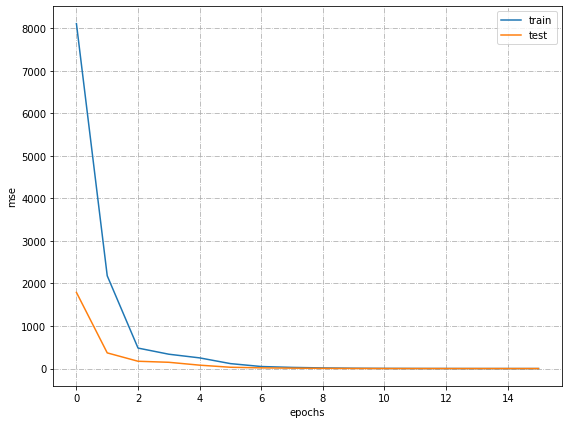

In [ ]:
# plot history
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.grid(True,linestyle='-.')
plt.xlabel('epochs')
plt.ylabel(loss0)
plt.legend()
plt.tight_layout()
plt.savefig(output_directories[0]+'/'+'loss'+str(n_steps_in)+'_'+str(n_steps_out)+'cluster'+str(i)+'.png')

In [ ]:

# demonstrate prediction
# dataset0_values=dataset0.values
# dataset=dataset0_values.reshape(dataset0.shape[0],dataset0.shape[1])
# X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input=Xtest
# x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
# print(yhat)
yhat.shape

(58, 6, 16)

In [ ]:
(ytest.shape,yhat.shape)

((58, 6, 16), (58, 6, 16))

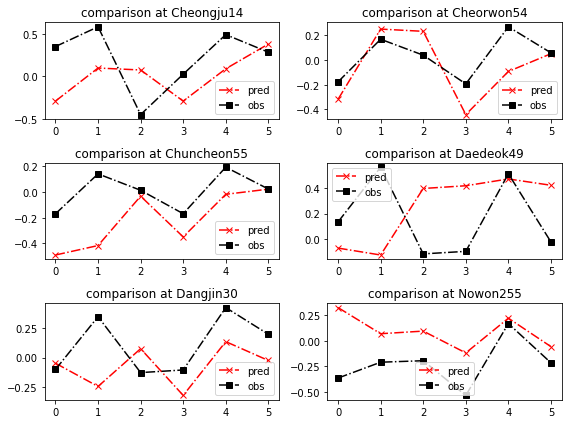

In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(8, 6))
gs=GridSpec(3,2)
k=-1
for i in range(3):
  for j in range(2):
    k+=1
    ax = fig.add_subplot(gs[i, j])
    ax=plt.plot(yhat[0,:,k],'-.x',color='red')
    ax=plt.plot(ytest[0,:,k],'-.s',color='black')
    ax=plt.legend(['pred','obs'])
    ax=plt.title('comparison at '+listi[k])

plt.tight_layout()
plt.savefig(output_directories[0]+'/'+str(n_steps_in)+'_'+str(n_steps_out)+'cluster'+str(i)+'.png')

# Error prediction

In [ ]:
rmse = sqrt(mean_squared_error(yhat[0,:,k], ytest[0,:,k]))
mape=mean_absolute_percentage_error(yhat[0,:,k], ytest[0,:,k])
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

Test RMSE: 0.374
Test MAPE: 261.950
